In [17]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)


notebook_dir = os.path.abspath("")

file_path = os.path.abspath(
    os.path.join(
        notebook_dir,
        "..",
        "results",
        "experiments",
        ExperimentFolders.O3,
        ExperimentFiles.ALL_TOOLS_MCP_SEQ,
    )
)


# Load JSON data (as list of dicts)
with open(file_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Data preparation

In [18]:
# Helper function to count contained and total facts
def count_facts(fact_list):
    if not isinstance(fact_list, list):
        return 0, 0
    total = len(fact_list)
    contained = sum(f.get("is_contained", False) for f in fact_list)
    return contained, total


# Apply to dataframe
df["direct_facts_contained"], df["direct_facts_total"] = zip(
    *df["fact_score.direct_facts"].apply(count_facts)
)
df["supporting_facts_contained"], df["supporting_facts_total"] = zip(
    *df["fact_score.supporting_facts"].apply(count_facts)
)

import numpy as np

# Define conditions based on the 'id' prefix
conditions = [
    df["id"].str.startswith("EA"),
    df["id"].str.startswith("MS"),
    df["id"].str.startswith("PS"),
    df["id"].str.startswith("STC"),
]

# Corresponding labels
labels = [
    "Extensibility Assistance",
    "Malaysia Support",
    "Peppol Support",
    "Settlement Cases",
]

# Create the new column
df["case_type"] = np.select(conditions, labels, default="Unknown")

df = df.sort_values(by="id")

In [19]:
# Define mapping for 'product' column
product_map = {
    "ERP (only SAP S/4HANA Cloud Public Edition)": "Public Cloud",
    "ERP (excluding SAP S/4HANA Cloud Public Edition)": "Non Public Cloud",
    "ERP": "All ERPs",
    "Peppol Service on Business Technology Platform": "Peppol",
    "DRC Cloud Edition on Business Technology Platform": "DRC",
    "Other": "Other",
}

# Apply mapping
df["product"] = df["product"].map(product_map).fillna(df["product"])

In [20]:
# Define mapping for 'category' column
category_map = {
    "How to Develop (Maintenance - Customer case support)": "How to Develop",
    "Documentation (Maintenance - Customer case support)": "Documentation",
    "Analysis (Development)": "Analysis",
    "How to Configure (Maintenance - Customer case support)": "How to Configure",
    "Initial error explanation and cause analysis (Maintenance - Customer case support)": "Error Analysis",
    "Coding (Development)": "Coding",
}

# Apply mapping
df["category"] = df["category"].map(category_map).fillna(df["category"])

In [21]:
# Define mapping for 'persona' column
persona_map = {
    "Developer (Customer side)": "Customer Developer",
    "Functional consultant (Customer side)": "Functional Consultant",
    "Architects (Software vendor side)": "Vendor Architect",
    "Developer (Software vendor side)": "Vendor Developer",
}

# Apply mapping
df["persona"] = df["persona"].map(persona_map).fillna(df["persona"])

# Data

In [ ]:
df.info()

In [ ]:
df

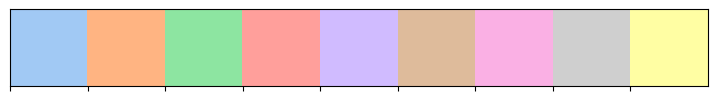

In [22]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

In [23]:
FONT_SIZE = 10

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_combined_factscore_and_outcome(
    df,
    group_col,
    boxplot_color,
    outcome_palette,
):
    """
    Creates two side-by-side plots:
    - Boxplot of fact_score.direct_fact_score.
    - Stacked bar of agent_judge_outcome.

    Sample sizes are shown above each group, and legends are positioned above each subplot.
    """
    # --- Preprocessing ---
    group_order = df[group_col].dropna().unique().tolist()
    desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
    counts = df[group_col].value_counts()

    # --- Figure Setup ---
    fig, axs = plt.subplots(
        1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 1.2]}
    )
    ax0, ax1 = axs

    # --- LEFT: Boxplot ---
    sns.boxplot(
        data=df,
        x=group_col,
        y="fact_score.direct_fact_score",
        order=group_order,
        color=boxplot_color,
        linewidth=1.5,
        showfliers=False,
        whis=[0, 100],
        ax=ax0,
    )

    # Add mean and median lines
    grouped = df.groupby(group_col)["fact_score.direct_fact_score"]
    medians = grouped.median()
    means = grouped.mean()

    for x, group in enumerate(group_order):
        mean = means.get(group)
        median = medians.get(group)

        if mean is not None:
            ax0.hlines(
                mean, x - 0.4, x + 0.4, colors="black", linestyles="--", linewidth=2
            )
            ax0.text(x, mean + 0.015, f"{mean:.2f}", ha="center", fontsize=FONT_SIZE)

        if median is not None:
            ax0.hlines(
                median, x - 0.4, x + 0.4, colors="black", linestyles="-", linewidth=1.5
            )
            ax0.text(
                x, median + 0.015, f"{median:.2f}", ha="center", fontsize=FONT_SIZE
            )

    ax0.set_ylim(-0.1, 1)
    ax0.set_ylabel("Direct FactScore")
    ax0.set_xlabel("")
    ax0.set_xticks(range(len(group_order)))
    ax0.set_xticklabels(group_order, rotation=45, ha="right")

    # Legend above left plot
    box_legend = [
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="Mean"),
        plt.Line2D(
            [0], [0], color="black", linestyle="-", linewidth=1.5, label="Median"
        ),
    ]
    ax0.legend(
        handles=box_legend,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.13),
        fontsize=FONT_SIZE,
        frameon=False,
        ncol=2,
    )

    # --- RIGHT: Stacked Bar Plot ---
    outcome_counts = (
        df.groupby([group_col, "agent_judge_outcome"]).size().unstack(fill_value=0)
    )

    # Ensure all expected groups and columns exist
    for group in group_order:
        if group not in outcome_counts.index:
            outcome_counts.loc[group] = [0] * len(outcome_counts.columns)
    outcome_counts = outcome_counts.loc[group_order]
    available_cols = [col for col in desired_order if col in outcome_counts.columns]
    outcome_counts = outcome_counts[available_cols]

    percent_data = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
    bottom = [0] * len(percent_data)

    for idx, outcome in enumerate(available_cols):
        values = percent_data[outcome].values
        ax1.bar(
            percent_data.index,
            values,
            bottom=bottom,
            label=outcome,
            color=outcome_palette[idx],
            edgecolor="gray",
        )

        # Annotate % values
        for i, (val, btm) in enumerate(zip(values, bottom)):
            if val >= 5:
                ax1.text(
                    i,
                    btm + val / 2,
                    f"{val:.0f}%",
                    ha="center",
                    va="center",
                    fontsize=FONT_SIZE,
                )

        bottom = [btm + val for btm, val in zip(bottom, values)]

    ax1.set_ylim(0, 110)
    ax1.set_ylabel("Distribution (%)")
    ax1.set_xticks(range(len(group_order)))
    ax1.set_xticklabels(group_order, rotation=45, ha="right")

    # Legend above right plot
    bar_legend = [
        plt.Rectangle((0, 0), 1, 1, color=outcome_palette[i], label=label)
        for i, label in enumerate(available_cols)
    ]
    ax1.legend(
        handles=bar_legend,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.13),
        fontsize=FONT_SIZE,
        frameon=False,
        ncol=len(bar_legend),
    )

    # --- Unified Sample Size Annotations (above each group) ---
    y0_max = ax0.get_ylim()[1]
    y1_max = ax1.get_ylim()[1]
    for x, group in enumerate(group_order):
        count = counts.get(group, 0)
        ax0.text(
            x,
            y0_max * 1.03,
            f"n={count}",
            ha="center",
            va="bottom",
            fontsize=10,
            color="gray",
        )
        ax1.text(
            x,
            y1_max * 1.03,
            f"n={count}",
            ha="center",
            va="bottom",
            fontsize=10,
            color="gray",
        )

    # Final layout
    fig.subplots_adjust(top=0.82, bottom=0.15, wspace=0.25)
    plt.show()

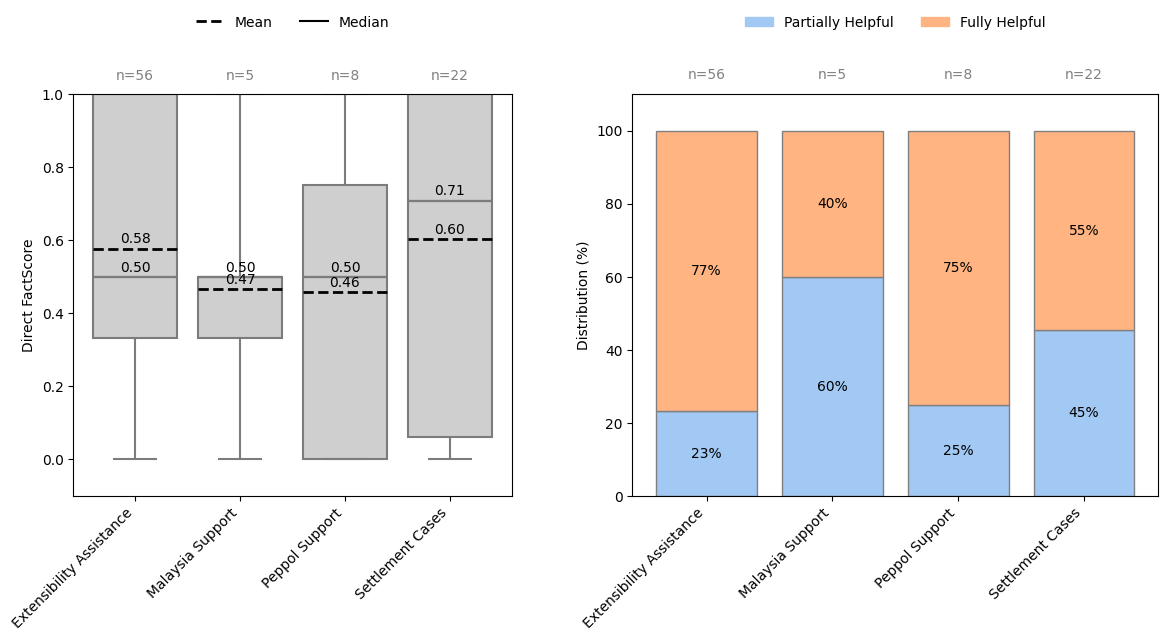

In [25]:
plot_combined_factscore_and_outcome(
    df,
    group_col="case_type",
    boxplot_color=my_palette[7],
    outcome_palette=my_palette,
)

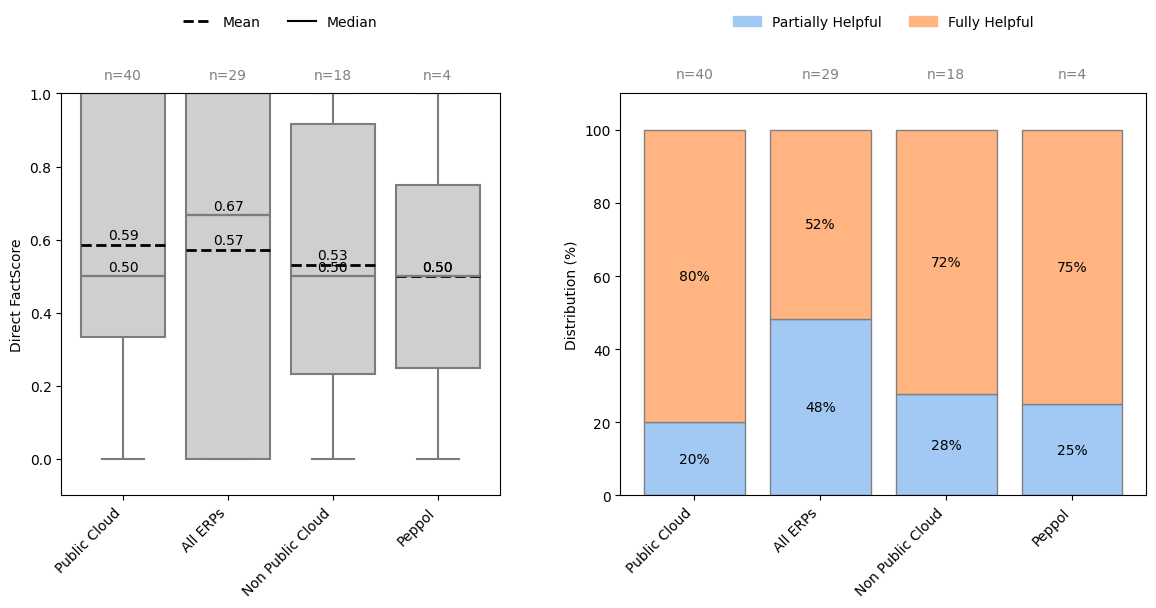

In [27]:
plot_combined_factscore_and_outcome(
    df,
    group_col="product",
    boxplot_color=my_palette[7],
    outcome_palette=my_palette,
)

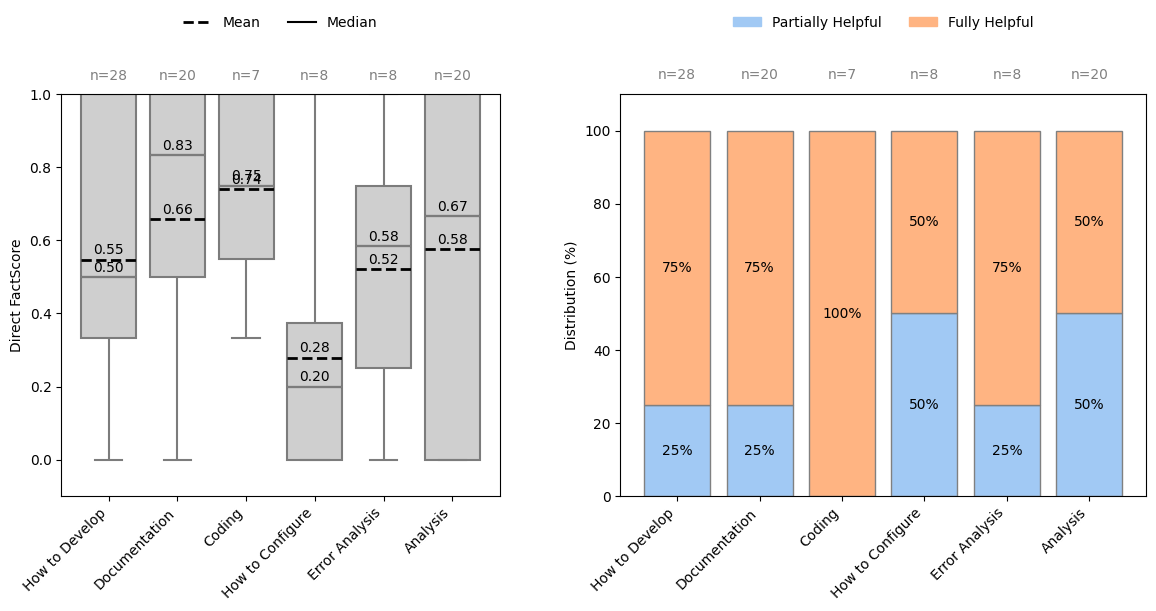

In [28]:
plot_combined_factscore_and_outcome(
    df,
    group_col="category",
    boxplot_color=my_palette[7],
    outcome_palette=my_palette,
)

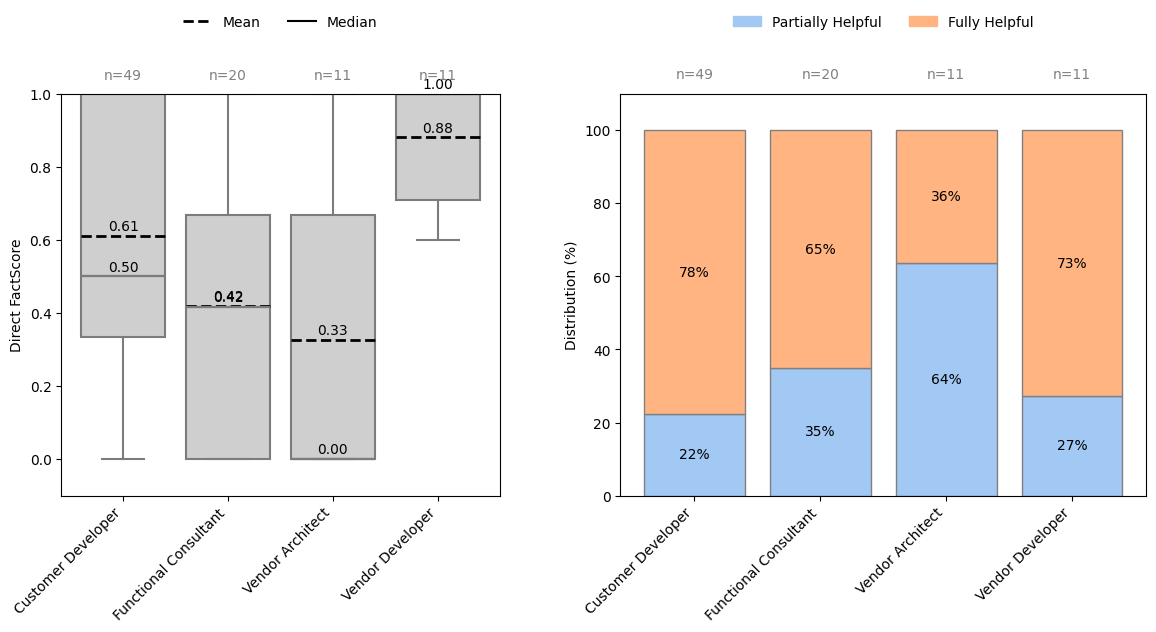

In [29]:
plot_combined_factscore_and_outcome(
    df,
    group_col="persona",
    boxplot_color=my_palette[7],
    outcome_palette=my_palette,
)

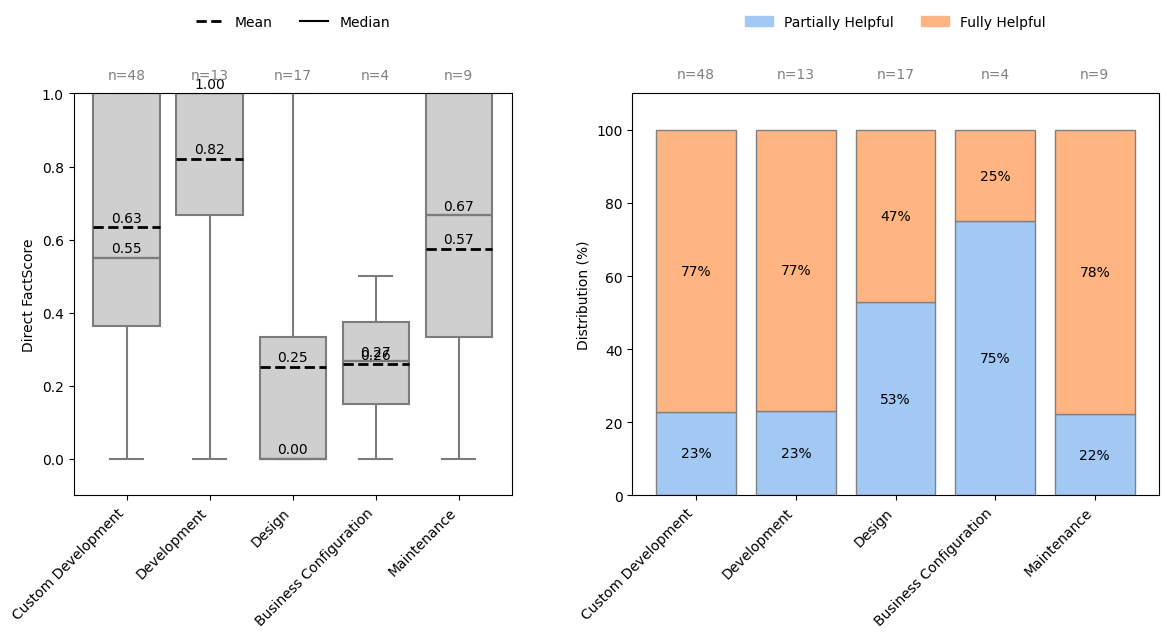

In [30]:
plot_combined_factscore_and_outcome(
    df,
    group_col="activity",
    boxplot_color=my_palette[7],
    outcome_palette=my_palette,
)

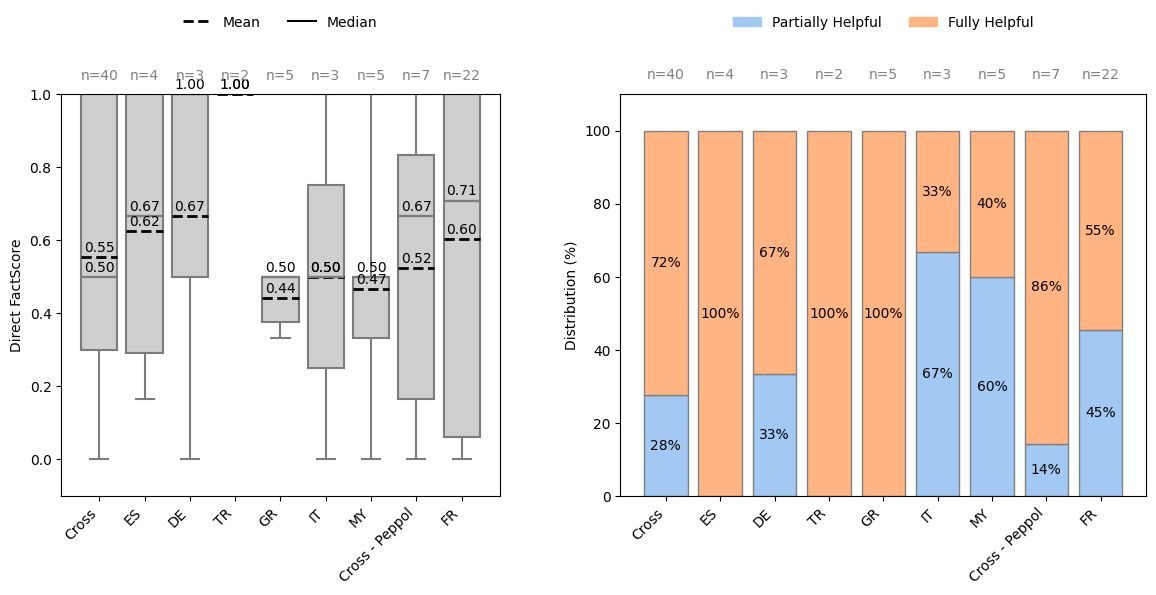

In [31]:
plot_combined_factscore_and_outcome(
    df,
    group_col="country",
    boxplot_color=my_palette[7],
    outcome_palette=my_palette,
)

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Initialize counter
tool_counts = Counter()

# Loop through each list of tools
for tools_list in df["tools_used"]:
    if isinstance(tools_list, list):
        for tool in tools_list:
            tool_name = tool.get("tool_name")
            if tool_name:
                tool_counts[tool_name] += 1

# Convert to DataFrame
tool_df = pd.DataFrame(tool_counts.items(), columns=["Tool Name", "Usage Count"])
tool_df = tool_df.sort_values(by="Usage Count", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(tool_df["Tool Name"], tool_df["Usage Count"], color="mediumseagreen")
plt.title("Distribution of Tool Usage Across Experiments")
plt.xlabel("Tool Name")
plt.ylabel("Usage Count")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# BERT Score per Experiment

In [ ]:
import matplotlib.pyplot as plt

# Define colors for each case_type
case_colors = {
    "Extensibility Assistance": "skyblue",
    "Malaysia Support": "orange",
    "Peppol Support": "green",
    "Settlement Cases": "red",
}

# Map colors to case_type
colors = df["case_type"].map(case_colors)

plt.figure(figsize=(14, 5))
plt.bar(df["id"], df["bert_score"], color=colors)
plt.xlabel("Experiment ID")
plt.ylabel("BERT Score")
plt.title("BERT Score per Experiment (Colored by Case Type)")
plt.ylim(-1, 1)
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()

# Create custom legend
from matplotlib.patches import Patch

legend_handles = [
    Patch(color=color, label=label) for label, color in case_colors.items()
]
plt.legend(
    handles=legend_handles,
    title="Case Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

plt.show()

# Fact Contained per Experiment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df))

plt.figure(figsize=(14, 6))

# Plot total and contained
plt.plot(
    x,
    df["direct_facts_total"],
    label="Direct Facts (Total)",
    color="orange",
    linewidth=2,
)
plt.plot(
    x,
    df["direct_facts_contained"],
    label="Direct Facts (Contained)",
    color="darkgreen",
    linestyle="--",
    linewidth=2,
)

# Fill area between lines
plt.fill_between(
    x,
    df["direct_facts_total"],
    df["direct_facts_contained"],
    where=(df["direct_facts_total"] > df["direct_facts_contained"]),
    interpolate=True,
    color="lightblue",
    alpha=0.3,
    label="Missed Direct Facts",
)

plt.xticks(x, df["id"], rotation=90)
plt.title("Direct Facts: Total vs Contained per Experiment")
plt.xlabel("Experiment ID")
plt.ylabel("Fact Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Time consumed for run

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    df["id"], df["excecution_time_seconds"], marker="o", linestyle="-", color="teal"
)

plt.title("Execution Time per Run")
plt.xlabel("Experiment ID")
plt.ylabel("Execution Time (seconds)")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))


# Plot input, output, and total tokens
plt.plot(
    df["id"],
    df["tokens_consumed.input_tokens"],
    label="Input Tokens",
    marker="o",
)
plt.plot(
    df["id"],
    df["tokens_consumed.output_tokens"],
    label="Output Tokens",
    marker="s",
)

plt.title("Token Consumption per Run (Excluding Agent Judge)")
plt.xlabel("Experiment ID")
plt.ylabel("Token Count")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()